# Fáza 2

**Michaela Gubovská, Jakub Hajdu**

V tejto fáze zealizujeme predspracovanie údajov pre strojové učenie.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import category_encoders as ce
from datetime import datetime
from sklearn.impute import SimpleImputer, KNNImputer
from copy import deepcopy

filename_p = "data/profiles.csv"
dfp = pd.read_csv(filename_p, sep='\t')

filename_l = "data/labor.csv"
dfl = pd.read_csv(filename_l, sep='\t')

Pôvodné neočistené dáta vyzerajú napríklad nasledovne:

In [2]:
dfp.head()

,Unnamed: 0,job,address,blood_group,ssn,birthdate,residence,race,name,sex
0,0,Quarry manager,"6269 Kelsey Cove\r\nJessicahaven, KY 76299",B+,818-49-6074,1925-12-31,30070 Anderson Branch Suite 371\r\nHoffmanberg...,White,Kimberly Frazier,F
1,1,Financial risk analyst,"72241 Luna Divide Suite 877\r\nMelindachester,...",B+,617-52-9894,"03/21/1912, 00:00:00","61551 Williams Shoal Apt. 506\r\nLunaborough, ...",Black,Timothy Gutierrez MD,M
2,2,Waste management officer,"6554 Nicole Lodge\r\nNorth Tanner, PA 59584",B+,690-88-6942,1960-11-19,77305 Palmer Valleys Suite 424\r\nJennifertown...,Black,Elaine Elliott,F
3,3,Publishing rights manager,"847 Taylor Court Apt. 547\r\nGutierrezfort, SD...",O+,767-13-0171,1978/11/14,"62021 Schwartz Roads\r\nJaimeville, SD 64413",Black,Richard Anderson,M
4,4,Medical sales representative,"83815 Richard Causeway Suite 275\r\nLemouth, W...",B+,412-57-1910,"03/14/1995, 00:00:00",Unit 4872 Box 1158\r\nDPO AA 51410,white,Jennifer Bass,F


In [3]:
dfl.head()

,Unnamed: 0,leukocyty,ssn,name,smoker,hemoglobin,trombocyty,indicator,alt,relationship,weight,ast,alp,hematokrit,hbver,etytr,er-cv,erytrocyty
0,0,5.90289,513-95-7625,Andrew Jacobs,no,7.54279,5.83096,1.0,17.60670,widowed,8.09544,42.92870,60.77098,6.50802,5.54259,6.57020,47.78400,5.46395
1,1,5.56403,025-71-2115,Ian Harrison,Y,7.87747,NaN,1.0,17.78037,single,73.58725,50.25507,47.14780,3.49169,3.52227,4.82276,55.62479,5.37924
2,2,6.24057,824-63-0108,Matthew Williams,no,4.72650,7.83234,1.0,25.25152,single,129.45079,25.15943,48.53570,8.65913,8.25976,5.64422,48.44629,6.52365
3,3,5.48374,157-32-2908,Charles Chavez,no,5.43079,5.36911,1.0,18.32802,divoced,18.61698,45.02094,73.77687,9.30190,6.26535,6.23014,50.48872,4.33766
4,4,6.04784,545-96-1267,Allen Chung MD,yes,8.85943,6.76682,1.0,11.03841,divoced,78.83355,59.06392,17.65112,4.47835,2.28488,7.83874,38.74892,5.17704


Ako prvé vykonáme základné úpravy dát z prvej fázy (EDA). Konkrétne očistíme tabuľky od nepotrebného stĺpca "Unnamed", zjednotíme hodnoty vo vybraných stĺpcoch (yes/no a pod.), upravíme stĺpec "birthdate" na iba rok narodenia a odstránime duplikáty z druhej tabuľky, nakoľko z EDA vieme, že v prvej sa duplikáty nenachádzajú.

In [4]:
dfp.drop('Unnamed: 0', axis=1, inplace=True)
dfp['race'] = dfp['race'].str.replace('white','White')
dfp['race'] = dfp['race'].str.replace('black','Black')
dfp['race'] = dfp['race'].str.replace('blsck','Black')
dfp['birthdate'] = (pd.to_datetime(dfp.birthdate)).dt.year


dfl.drop('Unnamed: 0', axis=1, inplace=True)
dfl = dfl.drop_duplicates()
dfl['smoker'] = dfl['smoker'].str.replace('N','no')
dfl['smoker'] = dfl['smoker'].str.replace('Y','yes')

Po týchto úpravách už vyzerajú naše dáta takto:

In [5]:
dfp.head()

,job,address,blood_group,ssn,birthdate,residence,race,name,sex
0,Quarry manager,"6269 Kelsey Cove\r\nJessicahaven, KY 76299",B+,818-49-6074,1925,30070 Anderson Branch Suite 371\r\nHoffmanberg...,White,Kimberly Frazier,F
1,Financial risk analyst,"72241 Luna Divide Suite 877\r\nMelindachester,...",B+,617-52-9894,1912,"61551 Williams Shoal Apt. 506\r\nLunaborough, ...",Black,Timothy Gutierrez MD,M
2,Waste management officer,"6554 Nicole Lodge\r\nNorth Tanner, PA 59584",B+,690-88-6942,1960,77305 Palmer Valleys Suite 424\r\nJennifertown...,Black,Elaine Elliott,F
3,Publishing rights manager,"847 Taylor Court Apt. 547\r\nGutierrezfort, SD...",O+,767-13-0171,1978,"62021 Schwartz Roads\r\nJaimeville, SD 64413",Black,Richard Anderson,M
4,Medical sales representative,"83815 Richard Causeway Suite 275\r\nLemouth, W...",B+,412-57-1910,1995,Unit 4872 Box 1158\r\nDPO AA 51410,White,Jennifer Bass,F


In [6]:
dfl.head()

,leukocyty,ssn,name,smoker,hemoglobin,trombocyty,indicator,alt,relationship,weight,ast,alp,hematokrit,hbver,etytr,er-cv,erytrocyty
0,5.90289,513-95-7625,Andrew Jacobs,no,7.54279,5.83096,1.0,17.60670,widowed,8.09544,42.92870,60.77098,6.50802,5.54259,6.57020,47.78400,5.46395
1,5.56403,025-71-2115,Ian Harrison,yes,7.87747,NaN,1.0,17.78037,single,73.58725,50.25507,47.14780,3.49169,3.52227,4.82276,55.62479,5.37924
2,6.24057,824-63-0108,Matthew Williams,no,4.72650,7.83234,1.0,25.25152,single,129.45079,25.15943,48.53570,8.65913,8.25976,5.64422,48.44629,6.52365
3,5.48374,157-32-2908,Charles Chavez,no,5.43079,5.36911,1.0,18.32802,divoced,18.61698,45.02094,73.77687,9.30190,6.26535,6.23014,50.48872,4.33766
4,6.04784,545-96-1267,Allen Chung MD,yes,8.85943,6.76682,1.0,11.03841,divoced,78.83355,59.06392,17.65112,4.47835,2.28488,7.83874,38.74892,5.17704


Pre ďalšie úpravy dát si tieto 2 tabuľky spojíme do jednej.

In [7]:
df = pd.merge(dfp, dfl, how="left", on=["ssn"])
df.head()

,job,address,blood_group,ssn,birthdate,residence,race,name_x,sex,leukocyty,...,alt,relationship,weight,ast,alp,hematokrit,hbver,etytr,er-cv,erytrocyty
0,Quarry manager,"6269 Kelsey Cove\r\nJessicahaven, KY 76299",B+,818-49-6074,1925,30070 Anderson Branch Suite 371\r\nHoffmanberg...,White,Kimberly Frazier,F,6.35996,...,16.37812,widowed,51.36819,43.29070,70.74271,7.45522,6.08021,5.85295,39.27380,4.42627
1,Quarry manager,"6269 Kelsey Cove\r\nJessicahaven, KY 76299",B+,818-49-6074,1925,30070 Anderson Branch Suite 371\r\nHoffmanberg...,White,Kimberly Frazier,F,6.11726,...,16.43658,married,29.84194,28.92169,82.95045,4.53835,6.37624,7.37613,46.09380,4.43045
2,Quarry manager,"6269 Kelsey Cove\r\nJessicahaven, KY 76299",B+,818-49-6074,1925,30070 Anderson Branch Suite 371\r\nHoffmanberg...,White,Kimberly Frazier,F,6.65582,...,15.94319,married,122.71392,46.08027,23.47025,4.54148,7.61836,6.73630,54.74172,5.24299
3,Quarry manager,"6269 Kelsey Cove\r\nJessicahaven, KY 76299",B+,818-49-6074,1925,30070 Anderson Branch Suite 371\r\nHoffmanberg...,White,Kimberly Frazier,F,6.77521,...,15.15328,nop,81.49556,32.56414,80.44580,4.35633,4.75844,7.14693,57.04543,4.27777
4,Financial risk analyst,"72241 Luna Divide Suite 877\r\nMelindachester,...",B+,617-52-9894,1912,"61551 Williams Shoal Apt. 506\r\nLunaborough, ...",Black,Timothy Gutierrez MD,M,5.99290,...,11.70433,widowed,65.37642,35.27976,22.40511,6.03565,6.26289,4.54114,71.58272,4.89556


Odstránime stĺpce, ktoré ďalej nebudeme používať - stĺpce ssn, mená, adresy, zamestnanie, a rodinný stav. Tieto stĺpce sú nám pre ďalšiu fázu strojového učenia zbytočné, nakoľko podľa nás nemajú vplyv na indikátor.

Odstránime aj stĺpce "blood_group" a "race", pretože sme zistili, že nemajú vplyv na indikátor, keďže pri každej skupine je pomer indikátora 0 a 1 približne rovnaký.

In [8]:
df.groupby(['blood_group', 'indicator']).size()

blood_group  indicator
A+           0.0          469
             1.0          842
A-           0.0          422
             1.0          776
AB+          0.0          447
             1.0          809
AB-          0.0          438
             1.0          782
B+           0.0          438
             1.0          783
B-           0.0          406
             1.0          758
O+           0.0          490
             1.0          839
O-           0.0          413
             1.0          806
dtype: int64

In [9]:
df.groupby(['race', 'indicator']).size()

race      indicator
Asian     0.0           370
          1.0           650
Black     0.0          1018
          1.0          1764
Hawaiian  0.0           177
          1.0           303
Indian    0.0           160
          1.0           317
White     0.0          1798
          1.0          3361
dtype: int64

In [10]:
df.drop('name_x', axis=1, inplace=True)
df.drop('name_y', axis=1, inplace=True)
df.drop('job', axis=1, inplace=True)
df.drop('address', axis=1, inplace=True)
df.drop('residence', axis=1, inplace=True)
df.drop('relationship', axis=1, inplace=True)
df.drop('blood_group', axis=1, inplace=True)
df.drop('race', axis=1, inplace=True)
df.drop('ssn', axis=1, inplace=True)
df.head()

,birthdate,sex,leukocyty,smoker,hemoglobin,trombocyty,indicator,alt,weight,ast,alp,hematokrit,hbver,etytr,er-cv,erytrocyty
0,1925,F,6.35996,no,7.05602,5.71857,1.0,16.37812,51.36819,43.29070,70.74271,7.45522,6.08021,5.85295,39.27380,4.42627
1,1925,F,6.11726,yes,6.47482,6.54765,1.0,16.43658,29.84194,28.92169,82.95045,4.53835,6.37624,7.37613,46.09380,4.43045
2,1925,F,6.65582,no,9.75669,8.89793,1.0,15.94319,122.71392,46.08027,23.47025,4.54148,7.61836,6.73630,54.74172,5.24299
3,1925,F,6.77521,no,6.89806,6.73572,1.0,15.15328,81.49556,32.56414,80.44580,4.35633,4.75844,7.14693,57.04543,4.27777
4,1912,M,5.99290,yes,8.93612,5.38672,1.0,11.70433,65.37642,35.27976,22.40511,6.03565,6.26289,4.54114,71.58272,4.89556


## 1. Integrácia a čistenie dát

### Zakódovanie nečíselných atribútov

Ako prvé si zakódujeme všetky nečíselné hodnoty, nakoľko pre ďalšiu fázu strojového učenia musí byť každé pozorovanie opísané jedným riadkom s iba numerickými hodnotami. Na zakódovanie použijeme One Hot encoder, ktorý pre daný stĺpec zakóduje hodnoty ako 0 alebo 1 (true or false) a vytvorí nové stĺpce, ktorých počet je rovný počtu rôznych kódovaných hodnôt.

In [11]:
# create an object of the OneHotEncoder
ce_OHE = ce.OneHotEncoder(cols=['sex', 'smoker'])

# fit and transform and you will get the encoded data
df = ce_OHE.fit_transform(df)
df = df.rename(columns={"sex_1": "sex_f", "sex_2": "sex_m", "smoker_1": "smoker_no", "smoker_2": "smoker_yes"})
df.head()

,birthdate,sex_f,sex_m,leukocyty,smoker_no,smoker_yes,hemoglobin,trombocyty,indicator,alt,weight,ast,alp,hematokrit,hbver,etytr,er-cv,erytrocyty
0,1925,1,0,6.35996,1,0,7.05602,5.71857,1.0,16.37812,51.36819,43.29070,70.74271,7.45522,6.08021,5.85295,39.27380,4.42627
1,1925,1,0,6.11726,0,1,6.47482,6.54765,1.0,16.43658,29.84194,28.92169,82.95045,4.53835,6.37624,7.37613,46.09380,4.43045
2,1925,1,0,6.65582,1,0,9.75669,8.89793,1.0,15.94319,122.71392,46.08027,23.47025,4.54148,7.61836,6.73630,54.74172,5.24299
3,1925,1,0,6.77521,1,0,6.89806,6.73572,1.0,15.15328,81.49556,32.56414,80.44580,4.35633,4.75844,7.14693,57.04543,4.27777
4,1912,0,1,5.99290,0,1,8.93612,5.38672,1.0,11.70433,65.37642,35.27976,22.40511,6.03565,6.26289,4.54114,71.58272,4.89556


Ďalším dôležitým krokom je identifikácia outlierov a chýbajúcich hodnôt. V tejto časti si ukážeme viaceré spôsoby na úpravu vychýlených a chýbajúcich hodnôt. Tento krok je dôležitý pre ďalšiu fázu machine learningu, aby sme mali pre vybraný algoritmus vhodný model.

### Chýbajúce hodnoty

Ako prvé sa pozrieme, koľko záznamov v našej tabuľke obsahuje aspoň jednu chýbajúcu (NaN) hodnotu. Toto vieme zistiť pomocou funkcie .dropna(), ktorá vráti dataframe očistený od záznamov obsahujúcich aspoň jednu chýbajúcu hodnotu.

In [12]:
len(df) - len(df.dropna())

324

Vidíme, že celkový počet záznamov s nejakou chýbajucou hodnotou je 324, čo predstavuje približne 3.2% záznamov. Nakoľko je táto hodnota menšia ako 5% (podľa prednášky odporúčaná hranica po ktorú je možné odstrániť takéto záznamy z datasetu), problém s chýbajúcimi hodnotami by sme mohli jednoducho vyriešiť odstránením záznamov s aspoň jednou chýbajúcou hodnotou príkazom ```df = df.dropna()```.

Iným postupom je nahradenie chýbajúcich hodnôt. Pozrieme sa, v ktorých stĺpcoch sa nachádzajú chýbajúce hodnoty.

Vidíme, že sa nachádzajú iba v stĺpcoch s číselnými hodnotami, čo nám vyhovuje, nakoľko v ďalších krokoch budeme používať SimpleImputer, ktorý vie pre chýbajúcu hodnotu podľa zvolenej stratégie vypočítať jej novú hodnotu na základe ostatných číselných hodnôt v danom stĺpci.

In [13]:
df.isnull().sum()

birthdate      0
sex_f          0
sex_m          0
leukocyty     30
smoker_no      0
smoker_yes     0
hemoglobin    30
trombocyty    30
indicator      0
alt           30
weight         0
ast           30
alp           30
hematokrit    30
hbver         30
etytr         30
er-cv         30
erytrocyty    30
dtype: int64

In [14]:
nan_columns = df.columns[df.isna().any()].tolist()
nan_columns

['leukocyty',
 'hemoglobin',
 'trombocyty',
 'alt',
 'ast',
 'alp',
 'hematokrit',
 'hbver',
 'etytr',
 'er-cv',
 'erytrocyty']

Pre neskoršie porovnávanie nahradených hodnôt rôznymi stratégiami si zapamätáme indexy záznamov, ktoré majú v stĺpci "leukocyty" chýbajúcu hodnotu.

In [15]:
nan_values_leukocyty = df[(df['leukocyty'].isna() == True)].index.values.astype(int)
nan_values_leukocyty

array([ 364,  830, 1097, 1437, 1733, 2224, 2440, 2764, 2998, 3047, 3678,
       3855, 4477, 4615, 4989, 5032, 5121, 5220, 6018, 6148, 6185, 6665,
       6758, 7275, 7508, 7509, 8059, 8325, 8430, 9071])

**Nahradenie chýbajúcich hodnôt mediánom**

In [16]:
# imputer
temp_median = deepcopy(df)
imp_median = SimpleImputer(strategy='median', missing_values=np.nan)
imp_median = imp_median.fit(temp_median[nan_columns])
temp_median[nan_columns] = imp_median.transform(temp_median[nan_columns])

print("Medián neupravených hodnôt leukocytov: ", df['leukocyty'].median())
temp_median.loc[nan_values_leukocyty].head()

Medián neupravených hodnôt leukocytov:  5.96288


,birthdate,sex_f,sex_m,leukocyty,smoker_no,smoker_yes,hemoglobin,trombocyty,indicator,alt,weight,ast,alp,hematokrit,hbver,etytr,er-cv,erytrocyty
364,1961,0,1,5.96288,0,1,8.66276,5.42962,1.0,14.19480,149.88153,59.99014,21.92037,3.75131,4.03378,7.07406,47.96724,5.96647
830,1989,1,0,5.96288,1,0,6.56560,6.41618,0.0,20.10001,36.83611,57.08964,90.38705,9.97760,3.83493,6.60584,52.08868,5.86690
1097,1908,0,1,5.96288,0,1,8.68357,6.37006,0.0,14.98156,97.99967,59.21069,31.22002,5.08591,6.26736,6.14819,53.05206,4.46374
1437,2001,1,0,5.96288,1,0,5.97156,5.93306,0.0,21.02052,124.48878,38.75679,92.50973,6.41064,7.78795,4.69995,60.77227,5.96222
1733,1978,1,0,5.96288,0,1,5.77229,7.56224,1.0,16.03531,48.81180,43.67445,81.88656,4.93636,6.54833,7.98907,33.41212,4.30801


Nahradili sme chýbajúce hodnoty mediánom hodnôt v danom stĺpci. V príklade tabuľky vyššie môžeme vidieť nahradené chýbajúce hodnoty leukocytov hodnotou mediána stĺpca "leukocyty".

Pre kontrolu si môžeme pozrieť, či sa v našej tabuľke už naozaj v žiadnom stĺpci nenachádzajú chýbajúce hodnoty.

In [17]:
temp_median.isnull().sum()

birthdate     0
sex_f         0
sex_m         0
leukocyty     0
smoker_no     0
smoker_yes    0
hemoglobin    0
trombocyty    0
indicator     0
alt           0
weight        0
ast           0
alp           0
hematokrit    0
hbver         0
etytr         0
er-cv         0
erytrocyty    0
dtype: int64

**Nahradenie chýbajúcich hodnôt priemerom**

In [18]:
# imputer
temp_mean = deepcopy(df)
imp_mean = SimpleImputer(strategy='mean', missing_values=np.nan)
imp_mean = imp_mean.fit(temp_mean[nan_columns])
temp_mean[nan_columns] = imp_mean.transform(temp_mean[nan_columns])

print("Priemer neupravených hodnôt leukocytov: ", df['leukocyty'].mean())
temp_mean.loc[nan_values_leukocyty].head()

Priemer neupravených hodnôt leukocytov:  5.963460102144014


,birthdate,sex_f,sex_m,leukocyty,smoker_no,smoker_yes,hemoglobin,trombocyty,indicator,alt,weight,ast,alp,hematokrit,hbver,etytr,er-cv,erytrocyty
364,1961,0,1,5.96346,0,1,8.66276,5.42962,1.0,14.19480,149.88153,59.99014,21.92037,3.75131,4.03378,7.07406,47.96724,5.96647
830,1989,1,0,5.96346,1,0,6.56560,6.41618,0.0,20.10001,36.83611,57.08964,90.38705,9.97760,3.83493,6.60584,52.08868,5.86690
1097,1908,0,1,5.96346,0,1,8.68357,6.37006,0.0,14.98156,97.99967,59.21069,31.22002,5.08591,6.26736,6.14819,53.05206,4.46374
1437,2001,1,0,5.96346,1,0,5.97156,5.93306,0.0,21.02052,124.48878,38.75679,92.50973,6.41064,7.78795,4.69995,60.77227,5.96222
1733,1978,1,0,5.96346,0,1,5.77229,7.56224,1.0,16.03531,48.81180,43.67445,81.88656,4.93636,6.54833,7.98907,33.41212,4.30801


Nahradili sme chýbajúce hodnoty priemerom hodnôt v danom stĺpci. V príklade tabuľky vyššie môžeme vidieť nahradené chýbajúce hodnoty leukocytov priemernou hodnotou stĺpca "leukocyty".

Pre kontrolu si môžeme pozrieť, či sa v našej tabuľke už naozaj v žiadnom stĺpci nenachádzajú chýbajúce hodnoty.

In [19]:
temp_mean.isnull().sum()

birthdate     0
sex_f         0
sex_m         0
leukocyty     0
smoker_no     0
smoker_yes    0
hemoglobin    0
trombocyty    0
indicator     0
alt           0
weight        0
ast           0
alp           0
hematokrit    0
hbver         0
etytr         0
er-cv         0
erytrocyty    0
dtype: int64

**Nahradenie chýbajúcich hodnôt pomerom ku korelovanému atribútu**

**Nahradenie chýbajúcich hodnôt pomocou kNN algoritmu**

Ako posledné sa pozrieme na stratégiu nahradenia chýbajúcich hodnôt pomocou kNN algoritmu. Pre každú chýbajúcu hodnotu sa zvolí 5 najbližších (najpodobnejších) záznamov s nie-NaN hodnotami v danom stĺpci, spriemeruje ich a túto hodnotu priradí. Túto stratégiu aplikujeme na celý dataframe, nakoľko ju považujeme za najpresnejší spôsob nahradenia chýbajúcej hodnoty, keďže berie pri výpočte novej hodnoty do úvahy podobné záznamy.

In [20]:
# imputer
imp_knn = KNNImputer(n_neighbors=5, weights='uniform', metric='nan_euclidean')
imp_knn.fit(df[nan_columns])
df[nan_columns] = imp_knn.transform(df[nan_columns])

df.loc[nan_values_leukocyty].head()

,birthdate,sex_f,sex_m,leukocyty,smoker_no,smoker_yes,hemoglobin,trombocyty,indicator,alt,weight,ast,alp,hematokrit,hbver,etytr,er-cv,erytrocyty
364,1961,0,1,5.595214,0,1,8.66276,5.42962,1.0,14.19480,149.88153,59.99014,21.92037,3.75131,4.03378,7.07406,47.96724,5.96647
830,1989,1,0,6.402176,1,0,6.56560,6.41618,0.0,20.10001,36.83611,57.08964,90.38705,9.97760,3.83493,6.60584,52.08868,5.86690
1097,1908,0,1,6.142742,0,1,8.68357,6.37006,0.0,14.98156,97.99967,59.21069,31.22002,5.08591,6.26736,6.14819,53.05206,4.46374
1437,2001,1,0,5.961904,1,0,5.97156,5.93306,0.0,21.02052,124.48878,38.75679,92.50973,6.41064,7.78795,4.69995,60.77227,5.96222
1733,1978,1,0,5.734782,0,1,5.77229,7.56224,1.0,16.03531,48.81180,43.67445,81.88656,4.93636,6.54833,7.98907,33.41212,4.30801


Nahradili sme chýbajúce hodnoty hodnotami získanými kNN algoritmom podľa 5 najpodobnejších záznamov. V príklade tabuľky vyššie môžeme vidieť nahradené chýbajúce hodnoty leukocytov. Hodnoty sa líšia, keďže pre každý záznam sa počítajú na základe iných piatich susedov.
Pre kontrolu si môžeme pozrieť, či sa v našej tabuľke už naozaj v žiadnom stĺpci nenachádzajú chýbajúce hodnoty.

In [21]:
df.isnull().sum()

birthdate     0
sex_f         0
sex_m         0
leukocyty     0
smoker_no     0
smoker_yes    0
hemoglobin    0
trombocyty    0
indicator     0
alt           0
weight        0
ast           0
alp           0
hematokrit    0
hbver         0
etytr         0
er-cv         0
erytrocyty    0
dtype: int64

In [22]:
df.weight.describe()

count    9918.000000
mean       70.675972
std        35.164592
min       -50.180020
25%        46.796368
50%        70.870875
75%        94.500495
max       204.381010
Name: weight, dtype: float64

### Vychýlené hodnoty

In [23]:
##funkcia na detekciu outlierov
def identify_outliers(a):
    lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
    upper = a.quantile(0.75) + 1.5 * stats.iqr(a)
    
    return a[(a > upper) | (a < lower)]

**Odstránenie vychýlených pozorovaní**

Ako prvé si identifikujeme vychýlené hodnoty naprieč stĺpcami v našom dataframe. Tieto nájdené hodnoty následne odstránime.

In [24]:
df.head()

,birthdate,sex_f,sex_m,leukocyty,smoker_no,smoker_yes,hemoglobin,trombocyty,indicator,alt,weight,ast,alp,hematokrit,hbver,etytr,er-cv,erytrocyty
0,1925,1,0,6.35996,1,0,7.05602,5.71857,1.0,16.37812,51.36819,43.29070,70.74271,7.45522,6.08021,5.85295,39.27380,4.42627
1,1925,1,0,6.11726,0,1,6.47482,6.54765,1.0,16.43658,29.84194,28.92169,82.95045,4.53835,6.37624,7.37613,46.09380,4.43045
2,1925,1,0,6.65582,1,0,9.75669,8.89793,1.0,15.94319,122.71392,46.08027,23.47025,4.54148,7.61836,6.73630,54.74172,5.24299
3,1925,1,0,6.77521,1,0,6.89806,6.73572,1.0,15.15328,81.49556,32.56414,80.44580,4.35633,4.75844,7.14693,57.04543,4.27777
4,1912,0,1,5.99290,0,1,8.93612,5.38672,1.0,11.70433,65.37642,35.27976,22.40511,6.03565,6.26289,4.54114,71.58272,4.89556


In [25]:
temp_df = deepcopy(df)
outliers = []
d = {}
for col in nan_columns + ['birthdate', 'weight']:
    x = identify_outliers(temp_df[col]).index.values.astype(int)
    d[col] = x
    for element in x:
        if element not in outliers:
            outliers.append(element)

print(len(outliers))

734


Nakoľko sme zistili, že počet záznamov patriacich medzi outlierov aspoň jedného atribútu je 734, čo pri celkovom počte pozorovaní predstavuje približne 7.4%. Nakoľko sa podľa prednášok neodporúča odstraňovať vychýlené hodnoty, ktorých počet presahuje 5% z celkového počtu záznamov, nepovažujeme za správne odstránenie záznamov obsahujúcich tieto vychýlené hodnoty. V prípade, že by ich počet bol <= 5% všetkých pozorovaní, odstránili by sme ich pomocou ```temp_df.drop(outliers, inplace=True)```

**Nahradenie vychýlenej hodnoty hraničnými hodnotami rozdelenia**

Pre zachovanie počtu záznamov nahradíme vychýlené hodnoty hraničnými hodnotami daného stĺpca. Konkrétne outlierov za maximom nahradíme hodnotou 95. percentilu a outlierov za minimom nahradíme hodnotou 5. percentilu.

In [26]:
##funkcia na detekciu outlierov, vrati oddelene zoznamy indexov prilis vysokych a prilis nizkych hodnot
def identify_outliers_low_up(a):
    lower = a.quantile(0.25) - 1.5 * stats.iqr(a)
    upper = a.quantile(0.75) + 1.5 * stats.iqr(a)
    
    return a[(a < lower)].index.values.astype(int), a[(a > upper)].index.values.astype(int)

In [27]:
##nahradenie hodnot outlierov hodnotami 5. a 95. percentilom rozlozenia
for col in nan_columns + ['birthdate', 'weight']:
    #print('\n', col) # nazov stlpca pre kontrolny vypis
    low, up = identify_outliers_low_up(df[col])
    #if (len(low) > 0): print('low[0]: ', df.loc[low[0], col]) ##prvy nizky outlier pre kontrolny vypis
    #if (len(up) > 0): print('up[0]: ', df.loc[up[0], col]) ##prvy vysoky outlier pre kontrolny vypis
    #print('0.05: ', df[col].quantile(0.05)) ##hodnota 5. percentilu, ktorou sa nahradzaju nizki outlieri
    #print('0.95: ', df[col].quantile(0.95)) ##hodnota 95. percentilu, ktorou sa nahradzaju vysoki outlieri
    df.loc[low, col] = df[col].quantile(0.05)
    df.loc[up, col] = df[col].quantile(0.95)
    #if (len(low) > 0): print('low[0]: ', df.loc[low[0], col]) ##prvy nizky outlier po nahradeni pre kontrolny vypis
    #if (len(up) > 0): print('up[0]: ', df.loc[up[0], col]) ##prvy vysoky outlier po nahradeni pre kontrolny vypis

## 2. Realizácia predspracovania dát

Naše stribúty dát si teraz pretranformujeme na vhodný formát pre ML. Použijeme slgoritmy MinMaxScaling a Power Transformer.

### Rozdelenie na trénovaciu a testovaciu sadu

Ako prvý krok prerozdelíme náš dataset na trénovaciu a testovaciu podmnožinu v pomere 75:25.
Sada X obsahuje všetky atribúty, ktorých vplyv na indikátor budeme sledovať. Sada Y obsahuje iba atribút indikátor.

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.loc[:, df.columns != 'indicator'], df['indicator'])
X_train.head()

,birthdate,sex_f,sex_m,leukocyty,smoker_no,smoker_yes,hemoglobin,trombocyty,alt,weight,ast,alp,hematokrit,hbver,etytr,er-cv,erytrocyty
6260,1935,0,1,5.98743,1,0,7.97530,5.57563,14.79788,25.06909,57.18674,44.52321,4.64543,5.52814,5.62851,50.31671,5.81524
353,2019,0,1,7.09161,0,1,6.71758,5.74186,9.15633,136.34056,55.20642,85.84199,3.41896,5.55829,7.15399,25.51724,4.21581
3378,1949,0,1,5.30810,1,0,6.55084,6.14780,18.58396,25.92333,58.17815,84.97787,8.07916,6.02539,6.56332,38.46571,3.93105
70,1985,1,0,5.84102,0,1,7.01855,7.30090,11.46893,112.18916,40.63865,80.01888,6.25188,7.35394,4.75191,66.51033,4.72035
4834,1950,0,1,7.69305,0,1,7.27437,5.73957,15.90894,37.99531,49.07688,68.87935,7.74154,4.12307,7.87532,57.37646,5.62233


Pre potreby poslednej časti tejto fázy (Pipeline) si spravíme kópiu ešte netransformovanej sady X.

In [29]:
X_train_pipe = deepcopy(X_train)
X_test_pipe = deepcopy(X_test)

Môžeme sa pozrieť na aktuálne rozloženie hodnôt atribútu hemoglobínu. Vidíme, že rozdelenie nie je normálne a takisto rozsah hodnôt sa nenachádza v rozmedzí 0 až 1.

(array([ 23.,  14.,  32.,  27.,  38.,  48.,  64.,  70., 136.,  87.,  88.,
         99., 128., 141., 146., 165., 198., 203., 247., 257., 262., 248.,
        273., 308., 297., 333., 319., 326., 308., 300., 284., 285., 255.,
        219., 198., 200., 164., 133.,  89., 116.,  75.,  71.,  42.,  36.,
         25.,  20.,   9.,  15.,   6.,  11.]),
 array([ 2.45362  ,  2.6259208,  2.7982216,  2.9705224,  3.1428232,
         3.315124 ,  3.4874248,  3.6597256,  3.8320264,  4.0043272,
         4.176628 ,  4.3489288,  4.5212296,  4.6935304,  4.8658312,
         5.038132 ,  5.2104328,  5.3827336,  5.5550344,  5.7273352,
         5.899636 ,  6.0719368,  6.2442376,  6.4165384,  6.5888392,
         6.76114  ,  6.9334408,  7.1057416,  7.2780424,  7.4503432,
         7.622644 ,  7.7949448,  7.9672456,  8.1395464,  8.3118472,
         8.484148 ,  8.6564488,  8.8287496,  9.0010504,  9.1733512,
         9.345652 ,  9.5179528,  9.6902536,  9.8625544, 10.0348552,
        10.207156 , 10.3794568, 10.5517576, 10

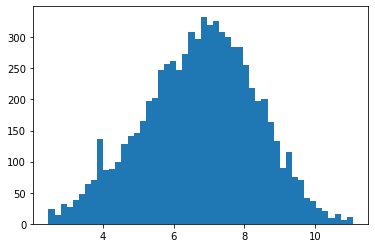

In [30]:
plt.hist(X_train['hemoglobin'], bins=50)

### Transformers

Dáta si transformujeme pomocou Power Transformera aby sme dosiahli rozdelenie hodnôt atribútov čo najbližšie normálnemu. Netransformujeme si však atribúty, ktoré nepotrebujeme transformovať - rok narodenia, pohlavie, fajčiar/nefajčiar.

In [31]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
transform_columns = nan_columns + ['weight']
passthrough_columns = ['birthdate', 'sex_f', 'sex_m', 'smoker_no', 'smoker_yes']

ct = ColumnTransformer(transformers=[("PT", PowerTransformer(method='yeo-johnson', standardize=True), transform_columns)], remainder='passthrough')
X_train = pd.DataFrame(ct.fit_transform(X_train), columns=transform_columns + passthrough_columns)
X_train.head()

,leukocyty,hemoglobin,trombocyty,alt,ast,alp,hematokrit,hbver,etytr,er-cv,erytrocyty,weight,birthdate,sex_f,sex_m,smoker_no,smoker_yes
0,0.036086,0.777780,-0.421213,-0.029979,0.752053,-0.556758,-1.106974,-0.329218,-0.330745,0.227713,0.928393,-1.322812,1935.0,0.0,1.0,1.0,0.0
1,1.165059,-0.035839,-0.249481,-1.444572,0.599622,1.168531,-1.895853,-0.309937,1.222333,-1.699684,-0.494125,1.865742,2019.0,0.0,1.0,0.0,1.0
2,-0.665106,-0.141183,0.167795,0.868270,0.828249,1.130610,1.054254,-0.007704,0.622794,-0.687631,-0.749036,-1.297455,1949.0,0.0,1.0,1.0,0.0
3,-0.114582,0.155846,1.338218,-0.851400,-0.532421,0.914314,-0.088459,0.886011,-1.230803,1.466163,-0.043777,1.185873,1985.0,1.0,0.0,0.0,1.0
4,1.775013,0.320297,-0.251843,0.237167,0.125732,0.437148,0.844213,-1.195030,1.951679,0.769166,0.757574,-0.941705,1950.0,0.0,1.0,0.0,1.0


Keď sa po transformácii pozrieme na hodnoty atribútu hemoglobín, vidíme, že sa rozdelenie viditeľne zmenilo na normálne.

(array([ 29.,  23.,  27.,  45.,  53.,  77.,  77., 149.,  85., 105., 129.,
        144., 161., 170., 193., 221., 228., 270., 268., 255., 272., 307.,
        291., 321., 324., 311., 307., 290., 292., 266., 244., 214., 202.,
        191., 165., 139., 110.,  80., 106.,  67.,  65.,  41.,  32.,  23.,
         22.,  10.,  12.,  10.,   7.,   8.]),
 array([-2.50186929, -2.39372257, -2.28557584, -2.17742912, -2.0692824 ,
        -1.96113568, -1.85298895, -1.74484223, -1.63669551, -1.52854879,
        -1.42040206, -1.31225534, -1.20410862, -1.0959619 , -0.98781517,
        -0.87966845, -0.77152173, -0.66337501, -0.55522828, -0.44708156,
        -0.33893484, -0.23078812, -0.12264139, -0.01449467,  0.09365205,
         0.20179877,  0.3099455 ,  0.41809222,  0.52623894,  0.63438566,
         0.74253239,  0.85067911,  0.95882583,  1.06697255,  1.17511928,
         1.283266  ,  1.39141272,  1.49955944,  1.60770617,  1.71585289,
         1.82399961,  1.93214633,  2.04029306,  2.14843978,  2.2565865 ,
 

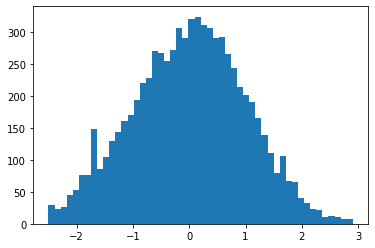

In [32]:
plt.hist(X_train['hemoglobin'], bins=50)

### Scaling

Ďalšiu techniku, ktorú aplikujeme je MinMaxScaling. Táto technika nám zabezpečí transformáciu hodnôt atribútov do rozmedzia od 0 po 1.

In [33]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_train.head()

,leukocyty,hemoglobin,trombocyty,alt,ast,alp,hematokrit,hbver,etytr,er-cv,erytrocyty,weight,birthdate,sex_f,sex_m,smoker_no,smoker_yes
0,0.510759,0.606518,0.433978,0.528093,0.645940,0.388672,0.311946,0.402169,0.441009,0.546485,0.672795,0.292007,0.258621,0.0,1.0,1.0,0.0
1,0.718651,0.456053,0.465339,0.270369,0.618257,0.836391,0.172491,0.405384,0.726753,0.195683,0.413968,0.854389,0.982759,0.0,1.0,0.0,1.0
2,0.381640,0.436571,0.541539,0.691745,0.659779,0.826550,0.693998,0.455779,0.616446,0.379885,0.367587,0.296480,0.379310,0.0,1.0,1.0,0.0
3,0.483015,0.491502,0.755276,0.378439,0.412660,0.770421,0.491994,0.604801,0.275411,0.771892,0.495909,0.734477,0.689655,1.0,0.0,0.0,1.0
4,0.830970,0.521914,0.464907,0.576765,0.532191,0.646594,0.656867,0.257799,0.860942,0.645034,0.641714,0.359225,0.387931,0.0,1.0,0.0,1.0


In [34]:
X_train.describe()

,leukocyty,hemoglobin,trombocyty,alt,ast,alp,hematokrit,hbver,etytr,er-cv,erytrocyty,weight,birthdate,sex_f,sex_m,smoker_no,smoker_yes
count,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000,7438.000000
mean,0.504114,0.462681,0.510897,0.533555,0.509356,0.533153,0.507631,0.457064,0.501861,0.505039,0.503874,0.525319,0.497829,0.509814,0.490186,0.589944,0.410056
std,0.184155,0.184946,0.182627,0.182202,0.181627,0.259521,0.176787,0.166756,0.183998,0.182020,0.181962,0.176387,0.288856,0.499937,0.499937,0.491877,0.491877
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.378696,0.335409,0.384940,0.410079,0.387281,0.299684,0.374077,0.325522,0.378947,0.378299,0.379114,0.403490,0.241379,0.000000,0.000000,0.000000,0.000000
50%,0.504793,0.467454,0.512505,0.532192,0.511134,0.587171,0.516870,0.467313,0.501066,0.507007,0.505165,0.528470,0.491379,1.000000,0.000000,1.000000,0.000000
75%,0.630885,0.592634,0.634672,0.656517,0.636413,0.770324,0.639680,0.587660,0.629547,0.629526,0.630081,0.647616,0.750000,1.000000,1.000000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Po aplikovaní scalingu vidíme napríklad na hodnotách atribútu hemoglobín zmenu v rozmedzí nadobúdaných hodnôt na rozpätie 0 až 1.

(array([ 29.,  23.,  27.,  45.,  53.,  77.,  77., 149.,  85., 105., 129.,
        144., 161., 170., 193., 221., 228., 270., 268., 255., 272., 307.,
        291., 321., 324., 311., 307., 290., 292., 266., 244., 214., 202.,
        191., 165., 139., 110.,  80., 106.,  67.,  65.,  41.,  32.,  23.,
         22.,  10.,  12.,  10.,   7.,   8.]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 <BarContainer object of 50 artists>)

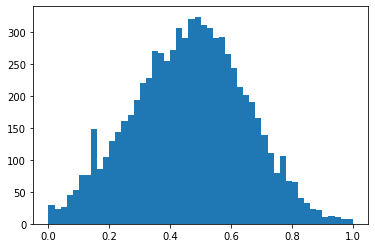

In [35]:
plt.hist(X_train['hemoglobin'], bins=50)

## 3. Výber atribútov pre strojové učenie

In [36]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

Pre výber najvhodnejších atribútov pre strojové učenie sme použili Mutual Information algoritmus, ktorý vyhodnotí závislosti medzi jednotlivými atribútmi. Čím vyššie číslo vyjde, tým je závislosť medzi danými atribútmi vyššia. My sme zisťovali závislosť indikátora od jednotlivých atribútov.

Pre väčšiu presnosť sme spustili algoritmus 5x a výsledky spriemerovali.

In [37]:
selector = SelectKBest(mutual_info_regression, k=5)
n = 5 ##overene s vyssim poctom testov, aktualne nastavene nizsie pre rychlejsi beh
scores = pd.Series((0 for col in X_train.columns), index=X_train.columns, dtype=float)
for i in range(n):
    selector.fit(X_train, y_train)
    mi_values = pd.Series(selector.scores_, index=X_train.columns)
    for col in mi_values.index:
        scores[col] += mi_values[col] / n
scores = scores.sort_values(ascending=False)
scores

hematokrit    7.855088e-02
hemoglobin    7.517369e-02
er-cv         1.229477e-02
erytrocyty    1.124532e-02
smoker_no     5.655678e-03
alt           5.269442e-03
alp           5.219359e-03
trombocyty    4.772494e-03
sex_m         4.290449e-03
etytr         4.166087e-03
birthdate     2.112097e-03
sex_f         6.192003e-04
ast           3.075360e-07
leukocyty     0.000000e+00
weight        0.000000e+00
hbver         0.000000e+00
smoker_yes    0.000000e+00
dtype: float64

Po zoradení všetkých skóre atribútov od najväčšieho po najmenšie sme zistili, že výrazný vplyv na indikátor majú práve atribúty hemoglobín a hematokrit. Ostatné atribúty majú nižší vplyv na indikátor a zároveň sa výška ich vplyvu mierne odlišuje pri každom spustení algoritmu. Preto sme sa rozhodli vybrať pre strojové učenie prvých 5 najvplyvnejších atribútov. Hodnoty vplyvu sme si zoradili zostupne a vybrali prvých 5, ktorými sú:

In [38]:
scores.index[0:5] ## 5 best

Index(['hematokrit', 'hemoglobin', 'er-cv', 'erytrocyty', 'smoker_no'], dtype='object')

Tu môžeme vidieť rovnaký výsledok (hemoglobín a hematokrit sú top 2 atribúty s najväčším vplyvom) použitím iného prístupu a to iba striktného vybratia k=5 najlepších atribútov.

In [39]:
X_best = SelectKBest(mutual_info_regression, k=5).fit_transform(X_train, y_train)
pd.DataFrame(X_best)

,0,1,2,3,4
0,0.606518,0.311946,0.546485,0.258621,0.0
1,0.456053,0.172491,0.195683,0.982759,1.0
2,0.436571,0.693998,0.379885,0.379310,0.0
3,0.491502,0.491994,0.771892,0.689655,1.0
4,0.521914,0.656867,0.645034,0.387931,1.0
...,...,...,...,...,...
7433,0.416354,0.280456,0.558092,0.931034,1.0
7434,0.385662,0.548671,0.462144,0.344828,1.0
7435,0.343836,0.515615,0.710152,0.818966,0.0
7436,0.151324,0.621053,0.461973,0.810345,0.0


## 4. Replikovateľnosť predspracovania

Náš doterajší kód predspracovania údajov pre strojové učenie sme v tejto časti upravili pomocou pipeline tak, aby ho bolo možné bez ďalších úprav znovu použiť na predspracovanie testovacej množiny.

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression

In [41]:
class Transformer(TransformerMixin):
    def __init__(self, transform_columns, passthrough_columns):
        self.transformer = ColumnTransformer(transformers=[("PT", PowerTransformer(method='yeo-johnson', standardize=True), transform_columns)], remainder='passthrough')
        self.columns = transform_columns + passthrough_columns
    
    def fit(self, X_pipe, y=None, **fit_params):
        self.transformer.fit(X_pipe)
        return self
        
    def transform(self, X_pipe, **transform_params):
        X_pipe = pd.DataFrame(self.transformer.transform(X_pipe), columns=self.columns)
        return X_pipe
        

In [42]:
class Scaler(TransformerMixin):
    def __init__(self):
        self.scaler = MinMaxScaler()
    
    def fit(self, X_pipe, y=None, **fit_params):
        self.scaler.fit(X_pipe)
        return self
        
    def transform(self, X_pipe, **transform_params):
        return pd.DataFrame(self.scaler.transform(X_pipe), columns=X_pipe.columns)

In [43]:
class FeatureSelector(TransformerMixin):
    def __init__(self):
        self.selector = SelectKBest(mutual_info_regression, k=5)
        
    def fit(self, X_pipe, y_pipe, **fit_params):
        self.y_ = y_pipe
        return self
        
    def transform(self, X_pipe, **transform_params):
        selector.fit(X_pipe, self.y_)
        scores = pd.Series((0 for col in X_train.columns), index=X_pipe.columns, dtype=float)
        mi_values = pd.Series(selector.scores_, index=X_pipe.columns)
        for col in mi_values.index:
            scores[col] = mi_values[col]
        scores = scores.sort_values(ascending=False)
        # zmenime poradie stlpcov X_pipe podla scores Series, aby mal rovnake poradie stlpcov
        X_pipe = X_pipe[scores.index]
        return X_pipe

In [44]:
transform_columns = ['leukocyty', 'hemoglobin', 'trombocyty', 'alt', 'ast', 'alp', 'hematokrit', 'hbver', 'etytr', 'er-cv', 'erytrocyty', 'weight']
passthrough_columns = ['birthdate', 'sex_f', 'sex_m', 'smoker_no', 'smoker_yes']

ppl = Pipeline([
    ('power-transformer', Transformer(transform_columns, passthrough_columns)),
    ('minmax-scaler', Scaler()),
    ('feature-selector', FeatureSelector())
])

In [45]:
ppl_transformed_train = ppl.fit_transform(X_train_pipe, y_train)
ppl_transformed_test = ppl.fit_transform(X_test_pipe, y_test)

Spracujeme trénovaciu a testovaciu sadu X pomocou nami vytvorenej pipeline, pričom výsledné dataframes obsahujú hodnoty atribútov po transformácii na normálne rozdelenie, po scalingu do rozsahu <0, 1>, a pričom poradie stĺpcov korešponduje so zoradením atribútov podľa dôležitosti hodnotenej pomocou Mutual information.

In [46]:
ppl_transformed_train.head()

,hematokrit,hemoglobin,er-cv,erytrocyty,alt,trombocyty,alp,smoker_yes,etytr,sex_m,sex_f,hbver,ast,weight,birthdate,smoker_no,leukocyty
0,0.311946,0.606518,0.546485,0.672795,0.528093,0.433978,0.388672,0.0,0.441009,1.0,0.0,0.402169,0.645940,0.292007,0.258621,1.0,0.510759
1,0.172491,0.456053,0.195683,0.413968,0.270369,0.465339,0.836391,1.0,0.726753,1.0,0.0,0.405384,0.618257,0.854389,0.982759,0.0,0.718651
2,0.693998,0.436571,0.379885,0.367587,0.691745,0.541539,0.826550,0.0,0.616446,1.0,0.0,0.455779,0.659779,0.296480,0.379310,1.0,0.381640
3,0.491994,0.491502,0.771892,0.495909,0.378439,0.755276,0.770421,1.0,0.275411,0.0,1.0,0.604801,0.412660,0.734477,0.689655,0.0,0.483015
4,0.656867,0.521914,0.645034,0.641714,0.576765,0.464907,0.646594,1.0,0.860942,1.0,0.0,0.257799,0.532191,0.359225,0.387931,0.0,0.830970


In [47]:
ppl_transformed_test.head()

,hematokrit,hemoglobin,sex_m,trombocyty,alt,birthdate,sex_f,weight,leukocyty,ast,erytrocyty,smoker_no,etytr,er-cv,hbver,alp,smoker_yes
0,0.316510,0.518488,1.0,0.628942,0.495272,0.896552,0.0,0.386971,0.400279,0.528561,0.422905,0.0,0.735129,0.192913,0.339643,0.625935,1.0
1,0.534963,0.411706,1.0,0.603572,0.519866,0.456897,0.0,0.506402,0.590228,0.711091,0.350761,1.0,0.546204,0.249781,0.840955,0.907702,0.0
2,0.348583,0.673527,0.0,0.109996,0.496141,0.284483,1.0,0.400881,0.643116,0.618489,0.689468,0.0,0.440657,0.490642,0.211614,0.177886,1.0
3,0.417516,0.813356,1.0,0.787416,0.196722,0.405172,0.0,0.691577,0.480512,0.629034,0.701593,1.0,0.855314,0.556712,0.308521,0.071576,0.0
4,0.788616,0.584698,1.0,0.546147,0.884654,0.870690,0.0,0.286634,0.532089,0.883521,0.917143,1.0,0.260979,0.287715,0.454211,0.515329,0.0


Vidíme, že prvých 5 stĺpcov s najvyšším skóre sa medzi trénovacou a testovacou sadou odlišuje. Potrebujeme však, aby obe sady obsahovali rovnakých 5 stĺpcov. Preto si túto množinu určíme  z testovacej sady a realizujeme výber tej istej podmnožiny atribútov nad oboma sadami. Vybrané najvyššie hodnotené atribúty si môžme vypísať:

In [48]:
selected_columns = ppl_transformed_train.columns[0:5]
print(selected_columns)
ppl_transformed_train = ppl_transformed_train[selected_columns]
ppl_transformed_test = ppl_transformed_test[selected_columns]

Index(['hematokrit', 'hemoglobin', 'er-cv', 'erytrocyty', 'alt'], dtype='object')


Výsledná trénovacia a testovacia X sada vyzerá nasledovne:

In [49]:
ppl_transformed_train.head()

,hematokrit,hemoglobin,er-cv,erytrocyty,alt
0,0.311946,0.606518,0.546485,0.672795,0.528093
1,0.172491,0.456053,0.195683,0.413968,0.270369
2,0.693998,0.436571,0.379885,0.367587,0.691745
3,0.491994,0.491502,0.771892,0.495909,0.378439
4,0.656867,0.521914,0.645034,0.641714,0.576765


In [50]:
ppl_transformed_test.head()

,hematokrit,hemoglobin,er-cv,erytrocyty,alt
0,0.316510,0.518488,0.192913,0.422905,0.495272
1,0.534963,0.411706,0.249781,0.350761,0.519866
2,0.348583,0.673527,0.490642,0.689468,0.496141
3,0.417516,0.813356,0.556712,0.701593,0.196722
4,0.788616,0.584698,0.287715,0.917143,0.884654


Na záver uložíme trénovacie a testovacie sady hodnôt sledovaných atribútov a taktiež príslušné hodnoty indikátora do jednotlivých súborov.

In [51]:
ppl_transformed_train.to_csv("data/X_train.csv", sep=',', index=False)
ppl_transformed_test.to_csv("data/X_test.csv", sep=',', index=False)
y_train.to_csv("data/y_train.csv", sep=',', index=False)
y_test.to_csv("data/y_test.csv", sep=',', index=False)